In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

import neuravi

CUDA AVAILABLE?  False
cpu


/Users/charles/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Size of dataset analysis

In [16]:
# Data import

prefix= ["0p10val","0p20val","0p30val","0p40val","0p50val","0p60val","0p70val","0p80val"]
suffix = ["_0","_1","_2","_3","_4","_5","_6","_7","_8","_9"]

# variable to record the results
total_size_train = np.zeros(len(prefix))
compo_size_train = np.zeros(len(prefix))
# order for errors is AG, MYEGA, A-M, Raman, Density, Entropy
error_size_train = np.zeros((len(prefix),len(suffix),6))
error_size_valid = np.zeros((len(prefix),len(suffix),6))
error_size_test = np.zeros((len(prefix),len(suffix),6))

# Loss criterion
criterion = torch.nn.MSELoss()

for j in range(len(prefix)): # main loop: between datasets

    # Load the good dataset
    dataset_name = "./data/DataSet_{}.hdf5".format(prefix[j])
    ds = neuravi.data_loader(dataset_name,"./data/NKAS_Raman.hdf5","./data/NKAS_density.hdf5",device)
    
    # saving in output variables
    total_size_train[j] = len(ds.T_visco_train)
    compo_size_train[j] = np.unique(ds.x_visco_train,axis=0).shape[0]
    
    for i in range(len(suffix)): # subloop: between each different training on one dataset
        
        # Loading the network and freezing dropout
        name_model = "model_l4_n200_p20_data{}{}.pth".format(prefix[j],suffix[i])
        neuralmodel = neuravi.model(4,200,4,ds.nb_channels_raman,p_drop=0.20) 
        neuralmodel.load_state_dict(torch.load("./model/exp_trainsize/"+name_model, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
    
        # train
        y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
        y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
        y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
        y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
        y_density_pred_train = neuralmodel.density(ds.x_density_train)
        y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)

        # valid
        y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
        y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
        y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
        y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
        y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
        y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)

        # test
        y_ag_pred_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)
        y_myega_pred_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)
        y_am_pred_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)
        #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
        y_density_pred_test = neuralmodel.density(ds.x_density_test)
        y_entro_pred_test = neuralmodel.sctg(ds.x_entro_test)

        # Compute Loss

        # train 
        error_size_train[j,i,0] = criterion(y_ag_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,1]  = criterion(y_myega_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,2]  = criterion(y_am_pred_train, ds.y_visco_train).item()
        error_size_train[j,i,3]  = criterion(y_raman_pred_train,ds.y_raman_train).item()
        error_size_train[j,i,4]  = criterion(y_density_pred_train,ds.y_density_train).item()
        error_size_train[j,i,5]  = criterion(y_entro_pred_train,ds.y_entro_train).item()

        # validation
        error_size_valid[j,i,0] = criterion(y_ag_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,1] = criterion(y_myega_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,2] = criterion(y_am_pred_valid, ds.y_visco_valid).item()
        error_size_valid[j,i,3] = criterion(y_raman_pred_valid,ds.y_raman_valid).item()
        error_size_valid[j,i,4] = criterion(y_density_pred_valid,ds.y_density_valid).item()
        error_size_valid[j,i,5] = criterion(y_entro_pred_valid,ds.y_entro_valid).item()

        # test
        error_size_test[j,i,0] = criterion(y_ag_pred_test, ds.y_visco_test).item()
        error_size_test[j,i,1] = criterion(y_myega_pred_test, ds.y_visco_test).item()
        error_size_test[j,i,2] = criterion(y_am_pred_test, ds.y_visco_test).item()
        #"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item()
        error_size_test[j,i,4] = criterion(y_density_pred_test,ds.y_density_test).item()
        error_size_test[j,i,5] = criterion(y_entro_pred_test,ds.y_entro_test).item()

## Figure

In [20]:
error_size_train.shape

(8, 10, 6)

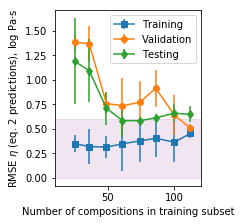

In [47]:
plt.figure(figsize=(3.22,3.22))

plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_train[:,:,0],axis=1)),
             yerr=np.std(error_size_valid[:,:,0],axis=1),
             marker = "s",color="C0",label="Training"
            )
plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_valid[:,:,0],axis=1)),
             yerr=np.std(error_size_valid[:,:,0],axis=1),
             marker = "o",color="C1",label="Validation"
            )
plt.errorbar(compo_size_train,
             np.sqrt(np.mean(error_size_test[:,:,0],axis=1)),
             yerr=np.std(error_size_test[:,:,0],axis=1),
             marker = "d",color="C2",label="Testing"
            )

plt.fill_between([0,120],[0,0.],[0.6,0.6],alpha=0.1,color="purple")

plt.xlim(10,120)

plt.legend()

plt.xlabel("Number of compositions in training subset")
plt.ylabel("RMSE $\eta$ (eq. 2 predictions), log Pa$\cdot$s")

plt.tight_layout()

plt.savefig("./figures/Figure_dataset_size.pdf")

In [50]:
np.std(np.sqrt(np.mean(error_size_train[:,:,0],axis=1)))

0.04275366583028762